In [36]:
import os
from pathlib import Path

cwd = Path.cwd()
if cwd.name == "notebooks":
    os.chdir(cwd.parent)

In [37]:
import pandas as pd
from mllm_emotion_classifier.utils import (
    add_fairness_metrics_to_df,
    plot_fairness_vs_hparam,
    plot_fairness_by_emotion,
    FigureCollector,
)
from EmoBox.EmoBox import EmoDataset

In [38]:
hparam = 'temperature' # or 'top_p'
assert hparam in ['temperature', 'top_p'], "hparam must be either 'temperature' or 'top_p'"

dataset = 'cremad'  # 'cremad', 'iemocap', 'emovdb'
fold = None # Set to an integer fold number if needed, else None to aggregate all folds
sensitive_attr = 'race' # gender, age, ethnicity, race
model = 'qwen2-audio-instruct'

metadata_dir = Path('EmoBox/data/')
dataset_path = metadata_dir / dataset
n_folds = len([d for d in dataset_path.iterdir() if d.is_dir() and d.name.startswith("fold_")])
out_dir = Path('outputs') / "temperature_runs" if hparam == 'temperature' else Path('outputs') / "topp_runs"

test = EmoDataset(dataset, './', metadata_dir, fold=1, split="test")
emotions = set(test.label_map.values())

if fold is None:
    dfs = []
    for f in range(1, n_folds + 1):
        results_csv = out_dir / model / dataset / f'fold_{f}.csv'
        df_fold = pd.read_csv(results_csv)
        dfs.append(df_fold)
    df = pd.concat(dfs, ignore_index=True)
else:
    results_csv = out_dir / model / dataset / f'fold_{fold}.csv'
    df = pd.read_csv(results_csv)

print(len(df), "rows")
df.head(5)

since there is no official valid data, use random split for train valid split, with a ratio of [80, 20]
load in 5586 samples, only 5586 exists in data dir EmoBox/data
load in 1856 samples, only 1856 exists in data dir EmoBox/data
Num. training samples 5586
Num. valid samples 0
Num. test samples 1856
Using label_map {'ANG': 'Angry', 'DIS': 'Disgust', 'FEA': 'Fear', 'HAP': 'Happy', 'NEU': 'Neutral', 'SAD': 'Sad'}
60 rows


,run,dataset,fold,model,prompt,temperature,valid_rate,global_f1_macro,global_f1_weighted,global_accuracy_unweighted,...,language_English_classwise_negative_predictive_value_Fear,language_English_classwise_negative_predictive_value_Happy,language_English_classwise_negative_predictive_value_Neutral,language_English_classwise_negative_predictive_value_Sad,language_English_classwise_f1_score_Angry,language_English_classwise_f1_score_Disgust,language_English_classwise_f1_score_Fear,language_English_classwise_f1_score_Happy,language_English_classwise_f1_score_Neutral,language_English_classwise_f1_score_Sad
0,0,cremad,1,qwen2-audio-instruct,user_labels,0.0001,1.0,0.7167,0.7125,0.7300,...,0.8857,0.9743,0.9903,0.9862,0.9082,0.4762,0.5409,0.8964,0.8828,0.5955
1,0,cremad,1,qwen2-audio-instruct,user_labels,0.3000,1.0,0.7568,0.7543,0.7618,...,0.9108,0.9696,0.9883,0.9823,0.9008,0.5644,0.6802,0.9027,0.8591,0.6337
2,0,cremad,1,qwen2-audio-instruct,user_labels,0.7000,1.0,0.7814,0.7801,0.7727,...,0.9282,0.9767,0.9624,0.9593,0.9114,0.6937,0.7353,0.8906,0.8350,0.6225
3,0,cremad,1,qwen2-audio-instruct,user_labels,1.0000,1.0,0.6218,0.7234,0.7263,...,0.9101,0.9652,0.9713,0.9598,0.8664,0.5757,0.5979,0.8866,0.8071,0.6190
4,0,cremad,1,qwen2-audio-instruct,user_labels,1.2000,1.0,0.6073,0.7071,0.7094,...,0.9169,0.9626,0.9636,0.9619,0.8784,0.5116,0.6422,0.8643,0.7657,0.5886


In [39]:
emotions

{'Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad'}

In [40]:
run = None
df = add_fairness_metrics_to_df(df, emotions, sensitive_attr=sensitive_attr, fairness_name='statistical_parity', run=run)
df = add_fairness_metrics_to_df(df, emotions, sensitive_attr=sensitive_attr, fairness_name='equal_opportunity', run=run)
df = add_fairness_metrics_to_df(df, emotions, sensitive_attr=sensitive_attr, fairness_name='equal_non_opportunity', run=run)
df = add_fairness_metrics_to_df(df, emotions, sensitive_attr=sensitive_attr, fairness_name='predictive_parity', run=run)
df = add_fairness_metrics_to_df(df, emotions, sensitive_attr=sensitive_attr, fairness_name='negative_predictive_parity', run=run)
df = add_fairness_metrics_to_df(df, emotions, sensitive_attr=sensitive_attr, fairness_name='overall_accuracy_equality', run=run)

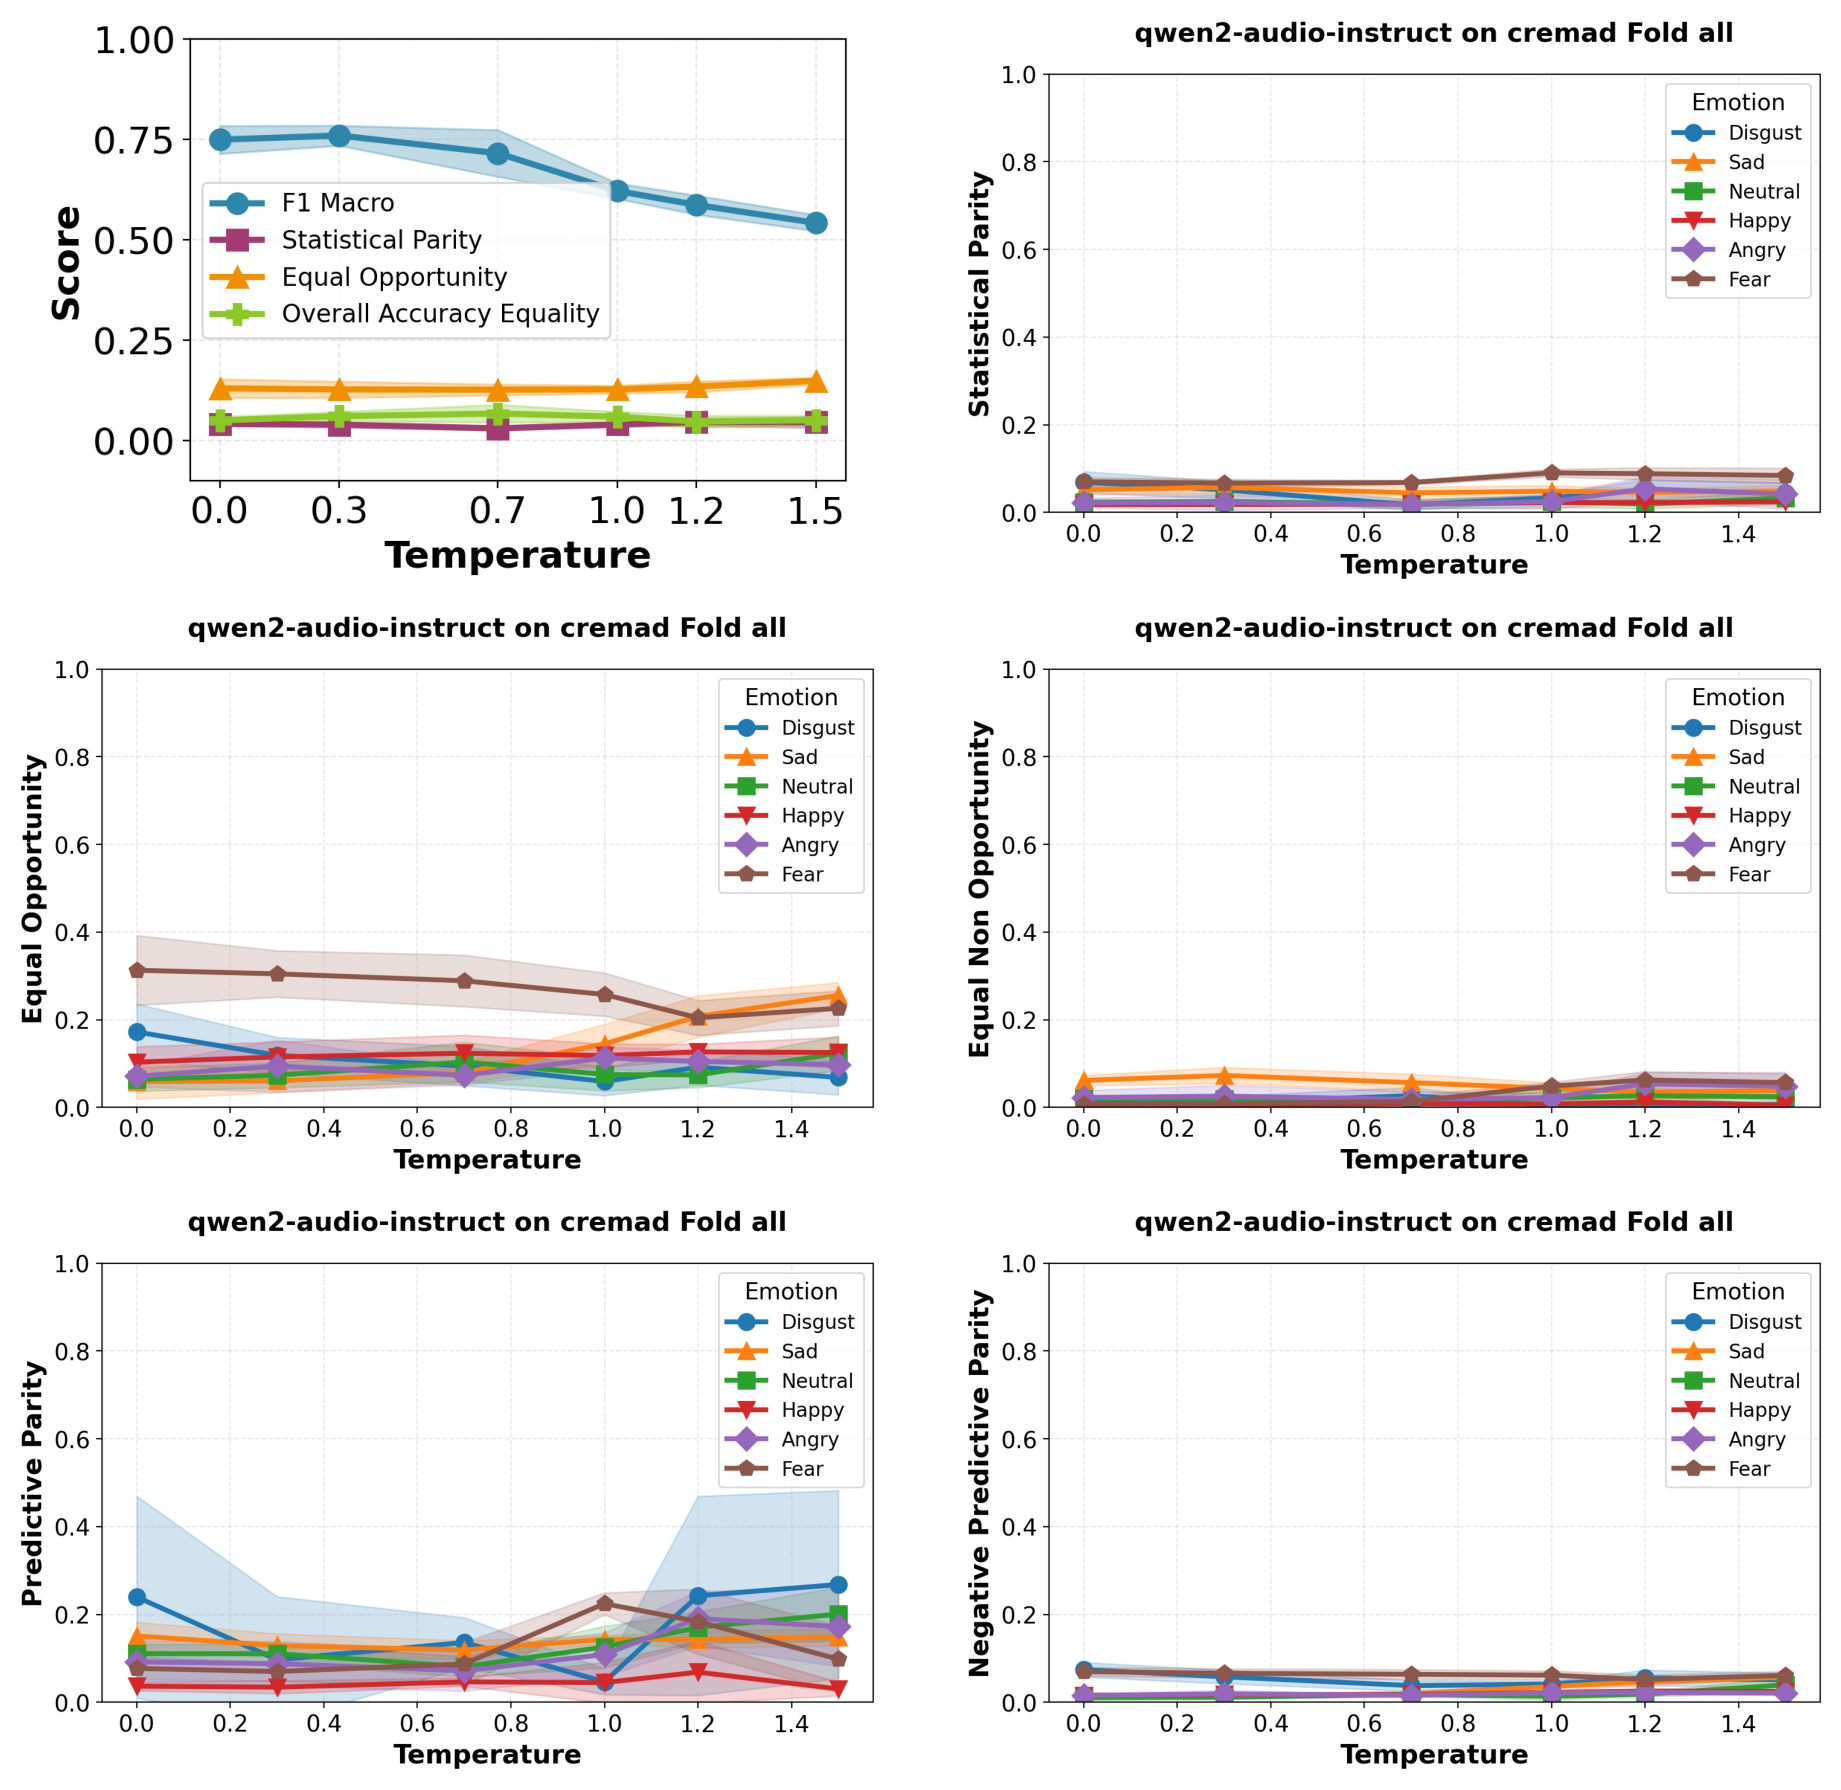

In [41]:
show_std = True
fold = fold if fold is not None else 'all'
os.makedirs(out_dir / 'figures', exist_ok=True)
outpath = out_dir / 'figures' / f'{dataset}_{sensitive_attr}_f1_fairness_fold_{fold}.png'

with FigureCollector() as collector:
    plot_fairness_vs_hparam(df, hparam, ['statistical_parity', 'equal_opportunity', 'overall_accuracy_equality'], sensitive_attr, model, dataset, fold, show_std=show_std, output_path=outpath)
    plot_fairness_by_emotion(df, emotions, hparam, 'statistical_parity', model, dataset, fold, show_std=show_std)
    plot_fairness_by_emotion(df, emotions, hparam, 'equal_opportunity', model, dataset, fold, show_std=show_std)
    plot_fairness_by_emotion(df, emotions, hparam, 'equal_non_opportunity', model, dataset, fold, show_std=show_std)
    plot_fairness_by_emotion(df, emotions, hparam, 'predictive_parity', model, dataset, fold, show_std=show_std)
    plot_fairness_by_emotion(df, emotions, hparam, 'negative_predictive_parity', model, dataset, fold, show_std=show_std)
    
collector.display_grid(nrows=3, ncols=2, figsize=(20, 18))
        # , title=f'Fairness Metrics by Emotion - {model} on {dataset} Fold {fold}')

In [42]:
show_std = True
with FigureCollector() as collector:
    plot_fairness_vs_hparam(df, hparam, ['statistical_parity', 'equal_opportunity'], model, dataset, fold, show_std=show_std)
    plot_fairness_by_emotion(df, emotions, hparam, 'statistical_parity', model, dataset, fold, show_std=show_std)
    plot_fairness_by_emotion(df, emotions, hparam, 'equal_opportunity', model, dataset, fold, show_std=show_std)
    
collector.display_grid(nrows=1, ncols=3, figsize=(20, 18))

TypeError: plot_fairness_vs_hparam() missing 1 required positional argument: 'fold'